## Import packages

In [8]:
#Import packages:
import re
from bs4 import BeautifulSoup
import requests
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from IPython.core.display import Image 

## Import wordlists from .py file

In [1]:
#Import wordlists
from genderwords_lists import *  
#Wordlists are kept hidden. But you may import any lists of words serving your purpose.

## Define functions to gather job data from JobIndex

### Ratelimit function

In [5]:
#Control the pace of calls to servers
import time
def ratelimit():
    "A function that handles the rate of calls."
    time.sleep(1) #change to design more clever schemes for handling the rate of calls.
    
#Reliable requests
def request(url,iterations=10,exceptions=(Exception)):
    for iteration in range(iterations):
        try:
            #add ratelimit function call here
            ratelimit() #!!
            response = session.get(url)
            return response #if succesful it will end the iterations here
        except exceptions as e: #find exceptions in the request library requests.exceptions
            print(e) #print or log the exception message.
    return None 

# Transparent scraping:
session = requests.session()
session.headers['email'] = 'youremail' 
session.headers['name'] = 'name'
session.headers

{'User-Agent': 'python-requests/2.11.1', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive', 'email': 'youremail', 'name': 'name'}

### Functions to extract links, names and sub-links of jobs

In [6]:
#Request text data from jobindex
def request_main_links(url_main):
    # Function to get links to jobs
    url=str(url_main)
    response = request(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    #Extract underlinks 
    links_main = []
    
    for div in soup.findAll('div', {'class': 'PaidJob'}):
        a = div.findAll('a')[1]
        links_main.append(a.attrs['href']) 
        
    return(links_main)

In [7]:
#Request text data from jobindex
def request_job_names(url_main):
    # Request main information from the given links (main pages)
    url=str(url_main)
    response = request(url)
    soup = BeautifulSoup(response.text, 'lxml')

    # Extract job names
    links_main_name = []
    
    for div in soup.findAll('div', {'class': 'PaidJob'}):
        if div is not None:
            b = div.find('b')
            links_main_name.append(b)
        
    return(links_main_name)

In [8]:
#Request name of companies
def request_company_names(url_main):
    # Request main information from the given links (main pages)
    url=str(url_main)
    response = request(url)
    soup = BeautifulSoup(response.text, 'lxml')
    
    # Get sub-links to each job from main pages
    job_containers = soup.find_all('div', class_ = 'PaidJob')
    links_company_name = []

    # Extract compnay names
    for i in job_containers:
        links_company_name.append(i.img["alt"])
    return(links_company_name)

### Functions to extract job texts and clean them

In [9]:
#Define function to clean html text.
def remove_html_tags(text):
    import re
    # Removes any HTML-tags 
    clean = re.compile('<.*?>')
    return re.sub(clean, '', text)

In [10]:
def extract_job_text(jobopslag):
    # Request information from the given link
    url= str(jobopslag)
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "lxml")
   
    # Extract text from underlinks (they are extracted in html format)
    text_job = soup.findAll('div', {'id': 'AdvertisementInnerContent'})
    text = str(text_job)
    
    # Use cleaner function to remove all HTML-tags in the texts
    tree = BeautifulSoup(text)
    good_html = tree.prettify()
    good_html = remove_html_tags(good_html)
    text = re.sub('[\r\n]', ' ', good_html)
    
    # Tokenizing and further cleaning text
    text = re.sub("[\\s]", " ", text, 0, 0)
    text = re.sub("[\.\t\,\:;\(\)\.]", "", text, 0, 0).split(" ")
    text = [ad for ad in text if ad != ""]
    text = [word.lower() for word in text]
    return(text)

### Functions to score text

In [11]:
def extract_job_text_score_man(jobopslag):
    text = jobopslag
    
    # Define empty vector for number of masculine words words
    masculine = []
    
    # Define wordlist for scoring
    masculine_coded_words = masculine_words
    
    # Pick a word in the job text, run it through the wordlist, search for matches, add 1 to empty vector if TRUE
    for word in text:
        for i in masculine_coded_words:
            if (word==i):
                masculine.append(word)
    return(masculine)

In [12]:
def extract_job_text_score_woman(jobopslag):
    text = jobopslag
    
    # Define empty vector for number of female words
    feminine = []
    
    # Define wordlist for scoring
    feminine_coded_words = feminine_words
        
    # Pick a word in the job text, run it through the wordlist, search for matches, add 1 to empty vector if TRUE
    for word in text:
        for i in feminine_coded_words:
            if (word==i):
                feminine.append(word)
    return(feminine)

In [13]:
def extract_job_text_score_communal(jobopslag):
    text = jobopslag
    
    # Define empty vector for number of pronoun words
    pronouns = 0
    
    # Define wordlist for scoring
    pronouns_words = ["vi","os","vores","jer"]
        
    # Pick a word in the job text, run it through the wordlist, search for matches, add 1 to empty vector if TRUE
    for word in text:
        for i in pronouns_words:
            if (word==i):
                pronouns = pronouns+1
    return(pronouns)

In [14]:
#Define function to extract text html from underlinks and score the texts:
def extract_job_text_score_individual(jobopslag):
    text = jobopslag
    
    # Define empty vector for number of communal words
    individual = 0
    
    # Define wordlist for scoring
    individual_words = ["jeg","mig","du","han","hun"]
        
    # Pick a word in the job text, run it through the wordlist, search for matches, add 1 to empty vector if TRUE
    for word in text:
        for i in individual_words:
            if (word==i):
                individual = individual+1
    return(individual)

In [15]:
# Count how early masculine words occur in text
def extract_job_text_score_count_man(jobopslag):
    text = jobopslag
    
    # Define wordlist for scoring
    masculine_coded_words = masculine_words
    
    # Count length of list prior to each match in words
    count_match =  [i for i, word in enumerate(text) if word in masculine_coded_words]
    
    return(count_match)

In [16]:
# Count how early feminine words occur in text
def extract_job_text_score_count_woman(jobopslag):
    text = jobopslag
    
    # Define wordlist for scoring
    feminine_coded_words = feminine_words
    
    # Count length of list prior to each match in words
    count_match =  [i for i, word in enumerate(text) if word in feminine_coded_words]
    
    return(count_match)

## Putting it all together - Extracting and scoring job texts from JobIndex

The algorithm is designed to score any text. However, as of now it is only adapted to scrape jobs from JobIndex that follow a certain HTML-design (Candidata-manager-HR). There are many jobs that follow this design, though. 

* All jobs following the candidate-manager HR HTML-setup: https://www.jobindex.dk/jobsoegning?page=3&q=https%3A%2F%2Fcandidate.hr-manager.net%2F

In [17]:
# Create main page links to loop over 
main_page_links = []

for i in range(2,43):
    page = "https://www.jobindex.dk/jobsoegning?page=NUMBER&q=https%3A%2F%2Fcandidate.hr-manager.net%2F" 
    pages = page.replace("NUMBER", str(i))
    main_page_links.append(pages)

In [18]:
#Extract main page links - put in main link for jobindex seach here:
links = []
names = []
company = []

for i in main_page_links:
    links.append(request_main_links(i))
    names.append(request_job_names(i))
    company.append(request_company_names(i))

# Change list of lists to a flat list
links = [item for sublist in links for item in sublist]
names = [item for sublist in names for item in sublist]
company = [item for sublist in company for item in sublist]

In [19]:
#Loop through links and extract job texts and score them through the algorithm:
masculine_score = []
feminine_score = []
communal_score = []
individual_score = []
masculine_count = []
feminine_count = []
job_text = []
job_text_length = []

# Extract and store job texts
for i in links: 
    job_text.append(extract_job_text(i))
    
# Get length of job texts
for i in job_text:
    length = len(i)
    job_text_length.append(length)

# Score eachjob text for male/female words
for i in job_text: 
    feminine_score.append(extract_job_text_score_woman(i))
    masculine_score.append(extract_job_text_score_man(i))
    communal_score.append(extract_job_text_score_communal(i))
    individual_score.append(extract_job_text_score_individual(i))
    masculine_count.append(extract_job_text_score_count_man(i))
    feminine_count.append(extract_job_text_score_count_woman(i))

## Converting raw data to a dataframe

In [20]:
# Some data wrangling 
f_count = []
for i in feminine_score:
    f_count.append(len(i))
    
m_count = []
for i in masculine_score:
    m_count.append(len(i))
    
m_early = []
for i in masculine_count:
    m_early.append(np.mean(i))
    
f_early = []
for i in feminine_count:
    f_early.append(np.mean(i))

In [ ]:
# Convert to dataframe
df = pd.DataFrame({"name": names,
                   "link": links,
                   "job_name": company, 
                   "masculine_words": masculine_score,
                   "masculine_count": m_count,
                   "feminine_count": f_count,
                   "feminine_words": feminine_score,
                   "communal": communal_score,
                   "individual": individual_score,
                   "masculine_early": masculine_count,
                   "feminine_early": feminine_count,
                   "average_early_man": m_early,
                   "average_early_woman": f_early,
                   "length": job_text_length},
                    columns=["name","job_name", "masculine_words", "feminine_words", "masculine_count","feminine_count", "communal", 
                             "individual", "masculine_early", "feminine_early","average_early_man", "average_early_woman", "length"])

# Clean name column for HTML-leftovers
df['name'] = df['name'].astype(str).str.replace(r"<b>", '')
df['name'] = df['name'].astype(str).str.replace(r"</b>", '')

# Analysis of results

### Divide into sectors

In [4]:
sectors = []

# A very simple solution to divide into sectors based on job name
for i in df["name"]:
    i = i.lower()
    if "IT" in i or "software" in i or "digital" in i or "udvikler" in i or "developer" in i:
        sectors.append("IT")
    elif "administrativ" in i:
        sectors.append("Service")
    elif "finans" in i or "aktuar" in i: 
        sectors.append("Finans og økonomi")
    elif "leder" in i or "chef" in i: 
        sectors.append("Ledelse")
    elif "salg" in i or "sælger" in i: 
        sectors.append("Salg")
    elif "hr" in i or "personale" in i: 
        sectors.append("HR")
    else:
        sectors.append("Andre")

# Append sector list to dataframe
df_new = df.copy()
series = pd.Series(sectors)
df_new['sector'] = series.values

# Calculate metrics by sector
grouped = df_new.groupby(["sector"]).mean()
grouped

,masculine_count,feminine_count,communal,individual,average_early_man,average_early_woman,length
sector,,,,,,,
Andre,1.391681,2.041594,11.584055,13.473137,255.313440,294.979551,522.764298
Finans og økonomi,3.250000,2.500000,15.625000,16.250000,284.879630,413.619048,642.875000
HR,1.764706,1.941176,14.529412,16.823529,361.393056,314.990842,540.941176
IT,1.628571,1.285714,11.028571,13.457143,297.743333,400.789286,590.771429
Ledelse,2.157407,2.037037,10.351852,16.777778,260.439937,297.844370,530.027778
Salg,1.365079,1.365079,22.619048,23.634921,317.719318,169.267974,551.539683
Service,0.666667,1.916667,11.000000,13.083333,493.300000,309.611111,562.583333


### Create visualizations of word counts:

In [12]:
import plotly.plotly as py
import plotly.graph_objs as go

# Add traces to bar chart. One for each sector
trace1 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["masculine_count"].iloc[0], grouped["feminine_count"].iloc[0]],
    name='Andre',
      marker=dict(
        color='rgb(109,125,178)'),
    opacity=1
)

trace2 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["masculine_count"].iloc[1], grouped["feminine_count"].iloc[1]],
    name='Finans og økonomi',
      marker=dict(
        color='rgb(217,91,87)'),
    opacity=1
)

trace3 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["masculine_count"].iloc[2], grouped["feminine_count"].iloc[2]],
    name='HR',
      marker=dict(
        color='rgb(109,127,64)'),
    opacity=1
)

trace4 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["masculine_count"].iloc[3], grouped["feminine_count"].iloc[3]],
    name='IT',
      marker=dict(
        color='rgb(63, 71, 98)'),
    opacity=1
)

trace5 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["masculine_count"].iloc[4], grouped["feminine_count"].iloc[4]],
    name='Ledelse',
      marker=dict(
        color='rgb(85, 85, 85)'),
    opacity=1
)

data = [trace1, trace2, trace3, trace4, trace5]

# Create bar chart
layout = go.Layout(
    barmode='group',
    title='Frekvens af kønnede ord i jobopslag på tværs af sektorer',
    font=dict(family='Corbel'),
    
    yaxis=dict(title='Gennemsnitlig frekvens af ord'),

    margin=go.Margin(
        l=200,
        r=50,
        b=80,
        t=100,
        pad=2),
)

fig = go.Figure(data=data, layout=layout)
v = py.iplot(fig, filename='grouped-bar')

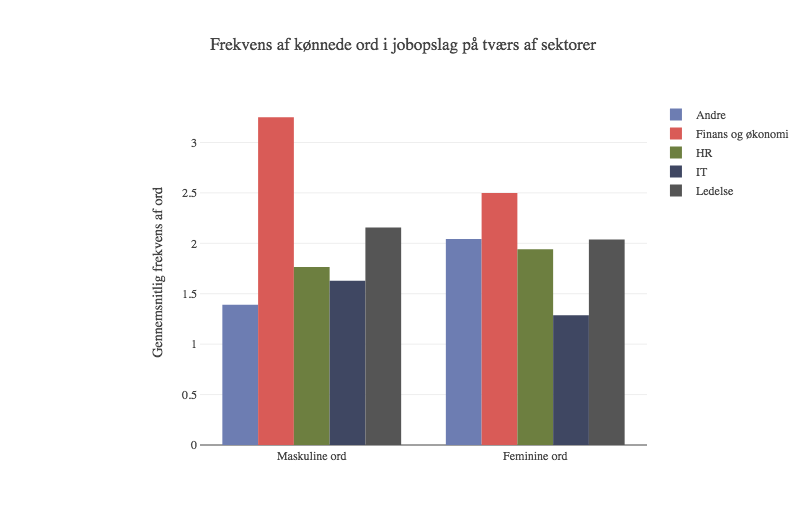

In [13]:
Image(filename='words1.png')

### Create visualizations of word placings:

In [6]:
import plotly.plotly as py
import plotly.graph_objs as go

# Add traces to bar chart. One for each sector
trace1 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["average_early_man"].iloc[0], grouped["average_early_woman"].iloc[0]],
    name='Andre',      
    marker=dict(
        color='rgb(109,125,178)'),
    opacity=1
)

trace2 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["average_early_man"].iloc[1], grouped["average_early_woman"].iloc[1]],
    name='Finans og økonomi',
      marker=dict(
        color='rgb(217,91,87)'),
    opacity=1
)

trace3 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["average_early_man"].iloc[2], grouped["average_early_woman"].iloc[2]],
    name='HR',
      marker=dict(
        color='rgb(109,127,64)'),
    opacity=1
)

trace4 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["average_early_man"].iloc[3], grouped["average_early_woman"].iloc[3]],
    name='IT',
      marker=dict(
        color='rgb(63, 71, 98)'),
    opacity=1
)

trace5 = go.Bar(
    x=["Maskuline ord", "Feminine ord"],
    y=[grouped["average_early_man"].iloc[4], grouped["average_early_woman"].iloc[4]],
    name='Ledelse',
      marker=dict(
        color='rgb(85, 85, 85)'),
    opacity=1
)

data = [trace1, trace2, trace3, trace4, trace5]

# Create bar chart
layout = go.Layout(
    barmode='group',
    title='Placering af kønnede ord i jobopslag på tværs af sektorer',
    font=dict(family='Corbel'),
    
yaxis=dict( title='Gennemsnitlig placering af ord'),
    margin=go.Margin(
        l=200,
        r=50,
        b=80,
        t=100,
        pad=2),
)

fig = go.Figure(data=data, layout=layout)
v = py.iplot(fig, filename='grouped-bar')

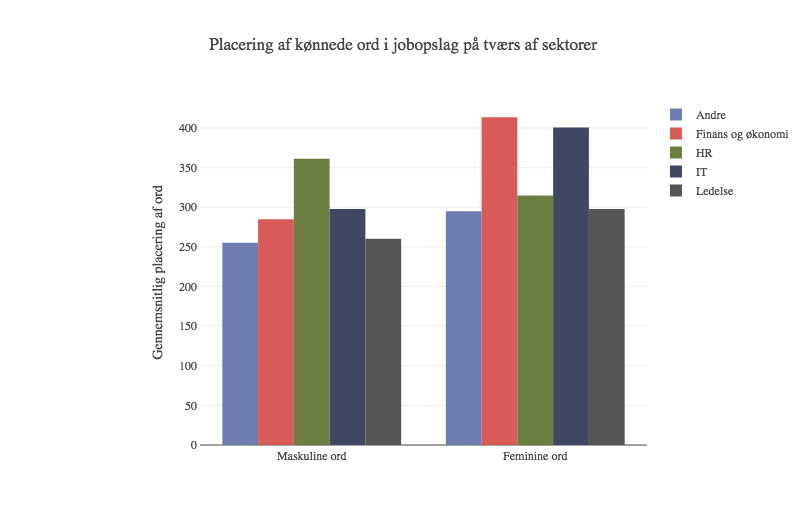

In [9]:
Image(filename='words2.png')